# 基因组模拟

基因组数据模拟的完整过程，包括三个主要情景的模拟和分析。

## 环境设置和导入

In [1]:
import stdpopsim
import tskit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import warnings
warnings.filterwarnings('ignore')

# 设置随机种子
np.random.seed(42)

# 配置matplotlib
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print(f"stdpopsim version: {stdpopsim.__version__}")
print(f"tskit version: {tskit.__version__}")

stdpopsim version: 0.3.0
tskit version: 0.6.4


## 基本配置

In [2]:
# 获取人类物种信息
species = stdpopsim.get_species("HomSap")
print(f"Species: {species.name}")
print(f"Generation time: {species.generation_time} years")

# 选择人口模型
model = species.get_demographic_model("OutOfAfrica_3G09")
print(f"\nDemographic model: {model.id}")
print(f"Populations: {[pop.name for pop in model.populations]}")

# 配置染色体22 (使用部分长度加快模拟)
contig = species.get_contig("chr22")  # , left=0, right=20_000_000
print("\nChromosome: chr22")
print(f"Length: {contig.length:,} bp")
print(f"Mutation rate: {contig.mutation_rate:.2e}")
if hasattr(contig, 'recombination_map'):
    print(f"Recombination rate: {contig.recombination_map.mean_rate:.2e}")

Species: Homo sapiens
Generation time: 30 years

Demographic model: OutOfAfrica_3G09
Populations: ['YRI', 'CEU', 'CHB']

Chromosome: chr22
Length: 50,818,468.0 bp
Mutation rate: 1.29e-08
Recombination rate: 2.11e-08


## 情景1: 东亚现代人群模拟

In [6]:
print("=" * 60)
print("情景1: 东亚现代人群模拟")
print("=" * 60)

# 定义样本
samples_s1 = {"CHB": 1000}
print(f"样本设置: {samples_s1}")

# 运行模拟
engine = stdpopsim.get_engine("msprime")
ts_scenario1 = engine.simulate(
    demographic_model=model,
    contig=contig,
    samples=samples_s1,
    seed=42
)

print("\n模拟完成!")
print(f"样本数: {ts_scenario1.num_samples:,}")
print(f"树数量: {ts_scenario1.num_trees:,}")
print(f"突变数: {ts_scenario1.num_mutations:,}")
print(f"序列长度: {ts_scenario1.sequence_length:,.0f} bp")

# 基本统计
diversity_s1 = ts_scenario1.diversity()
tajimas_d_s1 = ts_scenario1.Tajimas_D()
print(f"\n核苷酸多样性 (π): {diversity_s1:.6f}")
print(f"Tajima's D: {tajimas_d_s1:.6f}")

情景1: 东亚现代人群模拟
样本设置: {'CHB': 1000}

模拟完成!
样本数: 2,000
树数量: 41,450
突变数: 26,498
序列长度: 50,818,468 bp

核苷酸多样性 (π): 0.000033
Tajima's D: -1.391646


In [7]:
ts_scenario1.num_samples

2000

## 情景2: 三个现代人群模拟

In [8]:
print("=" * 60)
print("情景2: 三个现代人群模拟")
print("=" * 60)

# 定义样本
samples_s2 = {
    "YRI": 1000,  # 非洲人群
    "CEU": 1000,  # 欧洲人群
    "CHB": 1000   # 东亚人群
}
print(f"样本设置: {samples_s2}")

# 运行模拟
ts_scenario2 = engine.simulate(
    demographic_model=model,
    contig=contig,
    samples=samples_s2,
    seed=42
)

print("\n模拟完成!")
print(f"总样本数: {ts_scenario2.num_samples:,}")
print(f"树数量: {ts_scenario2.num_trees:,}")
print(f"突变数: {ts_scenario2.num_mutations:,}")
print(f"序列长度: {ts_scenario2.sequence_length:,.0f} bp")

# 基本统计
diversity_s2 = ts_scenario2.diversity()
tajimas_d_s2 = ts_scenario2.Tajimas_D()
print(f"\n核苷酸多样性 (π): {diversity_s2:.6f}")
print(f"Tajima's D: {tajimas_d_s2:.6f}")

情景2: 三个现代人群模拟
样本设置: {'YRI': 1000, 'CEU': 1000, 'CHB': 1000}

模拟完成!
总样本数: 6,000
树数量: 89,068
突变数: 56,493
序列长度: 50,818,468 bp

核苷酸多样性 (π): 0.000039
Tajima's D: -1.858159


In [ ]:
import itertools
import numpy as np

pop_labels = ["YRI", "CEU", "CHB"]

# 群体名 -> 群体ID
pop_ids = {pop.metadata["id"]: pop.id for pop in ts_scenario2.populations()}

# 按顺序取出样本节点
sample_sets = [ts_scenario2.samples(population=pop_ids[name])
               for name in pop_labels]

# 生成所有两两组合索引 (0,1), (0,2), (1,2)
indexes = list(itertools.combinations(range(len(pop_labels)), 2))

# 计算 Fst
fst_pairs = ts_scenario2.Fst(sample_sets, indexes=indexes)   # 返回一维数组，长度=3

# 填成 3×3 对称矩阵
fst_matrix = np.zeros((3, 3))
for idx, (i, j) in enumerate(indexes):
    fst_matrix[i, j] = fst_pairs[idx]
    fst_matrix[j, i] = fst_pairs[idx]      # 对称

# 加上行列名
fst_df = pd.DataFrame(fst_matrix,
                      index=pop_labels,
                      columns=pop_labels)
#fst_df.to_csv("/home/qmtang/mnt_qmtang/EvoFill/data/sim_s2_250901/fst_matrix.csv")
print(fst_df)

          YRI       CEU       CHB
YRI  0.000000  0.092069  0.098935
CEU  0.092069  0.000000  0.066966
CHB  0.098935  0.066966  0.000000


In [10]:
import pandas as pd

# 1. population 映射
pop_id2name = {pop.id: pop.metadata["id"] for pop in ts_scenario2.populations()}

# 2. 样本节点 -> 个体 ID
node2ind = {n: ts_scenario2.node(n).individual for n in ts_scenario2.samples()}

# 3. 按个体输出（每个个体 2 条染色体，但 VCF 样本名只列一次）
vcf_names = []
for ind in ts_scenario2.individuals():
    pop_prefix = pop_id2name[ind.population]
    # 每个个体只在 VCF 里出现一次（tskit 默认命名规则）
    vcf_names.append(f"{pop_prefix}_{ind.id}")

print("VCF 样本数（=个体数）:", len(vcf_names))        # 3000
print("前 10 个:", vcf_names[:10])
print("后 10 个:", vcf_names[-10:])

VCF 样本数（=个体数）: 3000
前 10 个: ['YRI_0', 'YRI_1', 'YRI_2', 'YRI_3', 'YRI_4', 'YRI_5', 'YRI_6', 'YRI_7', 'YRI_8', 'YRI_9']
后 10 个: ['CHB_2990', 'CHB_2991', 'CHB_2992', 'CHB_2993', 'CHB_2994', 'CHB_2995', 'CHB_2996', 'CHB_2997', 'CHB_2998', 'CHB_2999']


In [13]:
import io
import subprocess
# 1. 群体映射
pop_id2name = {pop.id: pop.metadata["id"] for pop in ts_scenario2.populations()}
name2id = {v: k for k, v in pop_id2name.items()}

# 2. 取出个体 ID 列表（与 VCF 顺序一致）
yri_ceu_ind = [ind.id for ind in ts_scenario2.individuals()
               if ind.population in (name2id["YRI"], name2id["CEU"])]
chb_ind     = [ind.id for ind in ts_scenario2.individuals()
               if ind.population == name2id["CHB"]]

print("YRI+CEU 个体数:", len(yri_ceu_ind))
print("CHB 个体数:", len(chb_ind))

for subset, label in [(yri_ceu_ind, "YRI_CEU"), (chb_ind, "CHB")]:
    out_vcf_gz = f"/home/qmtang/mnt_qmtang/EvoFill/data/sim_s2_250901/{label}_chr22.vcf.gz"
    # 2. 文本流 → gzip
    with subprocess.Popen(["gzip", "-c"],           # 输出到 stdout
                          stdin=subprocess.PIPE,
                          stdout=open(out_vcf_gz, "wb")) as gz:
        # 先写进内存文本缓冲区
        txt = io.StringIO()
        ts_scenario2.write_vcf(txt,
                     individuals=subset,
                     contig_id="chr22")
        # 一次性编码并压入 gzip
        gz.communicate(input=txt.getvalue().encode())

# 4. 验证行数
for label in ["YRI_CEU", "CHB"]:
    vcf = f"/home/qmtang/mnt_qmtang/EvoFill/data/sim_s2_250901/{label}_chr22.vcf.gz"
    cnt = int(subprocess.check_output(f"bcftools view -H {vcf} | wc -l", shell=True))
    print(f"{label} 变异行数:", cnt)

YRI+CEU 个体数: 2000
CHB 个体数: 1000
YRI_CEU 变异行数: 56145
CHB 变异行数: 56145


## 情景3: 古代+现代人群模拟

In [1]:
print("=" * 60)
print("情景3: 古代+现代人群模拟")
print("=" * 60)

# 定义样本 (更大的样本量以包含古代样本)
samples_s3 = {
    "YRI": 2000,  # 非洲人群
    "CEU": 2000,  # 欧洲人群
    "CHB": 2000   # 东亚人群
}
print(f"样本设置: {samples_s3}")

# 运行模拟
ts_scenario3 = engine.simulate(
    demographic_model=model,
    contig=contig,
    samples=samples_s3,
    seed=42
)

print("\n模拟完成")
print(f"总样本数: {ts_scenario3.num_samples:,}")
print(f"树数量: {ts_scenario3.num_trees:,}")
print(f"突变数: {ts_scenario3.num_mutations:,}")
print(f"序列长度: {ts_scenario3.sequence_length:,.0f} bp")

# 基本统计
diversity_s3 = ts_scenario3.diversity()
tajimas_d_s3 = ts_scenario3.Tajimas_D()
print(f"\n核苷酸多样性 (π): {diversity_s3:.6f}")
print(f"Tajima's D: {tajimas_d_s3:.6f}")

情景3: 古代+现代人群模拟
样本设置: {'YRI': 2000, 'CEU': 2000, 'CHB': 2000}


NameError: name 'engine' is not defined

## 模拟结果对比


模拟结果对比
                   Scenario  Samples  Trees  Mutations  Diversity  Tajimas_D
           Scenario 1 (CHB)     2000  41450      26498   0.000033  -1.391646
        Scenario 2 (3 Pops)     6000  89068      56493   0.000039  -1.858159
Scenario 3 (Ancient+Modern)    12000 108295      68837   0.000039  -1.928489


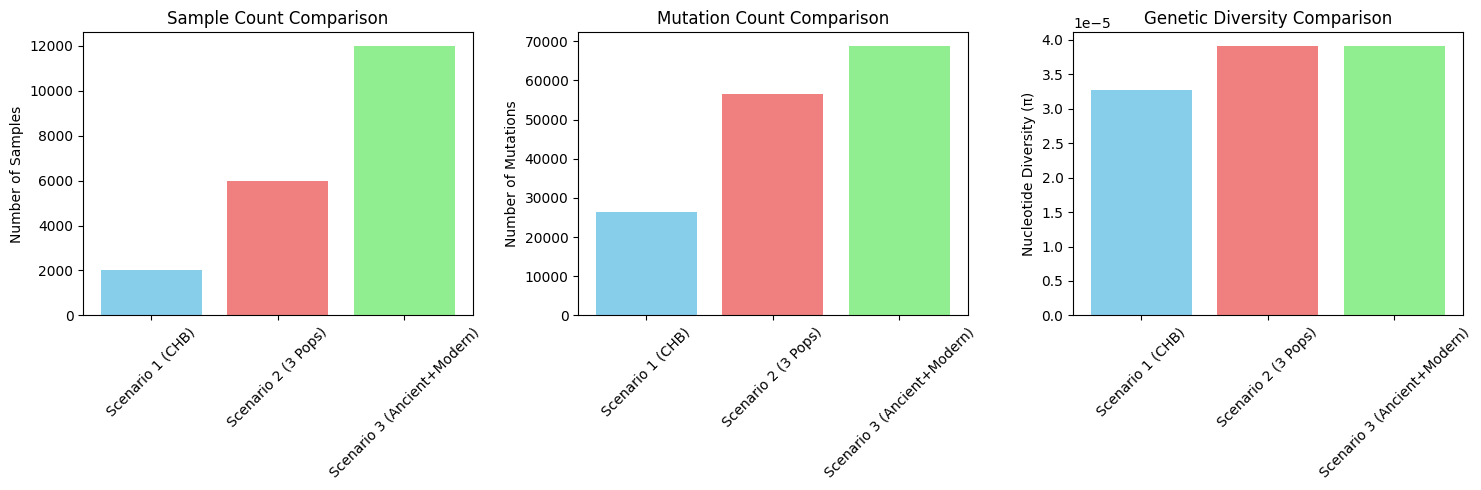

In [10]:
# 创建对比表格
comparison_data = {
    'Scenario': ['Scenario 1 (CHB)', 'Scenario 2 (3 Pops)', 'Scenario 3 (Ancient+Modern)'],
    'Samples': [ts_scenario1.num_samples, ts_scenario2.num_samples, ts_scenario3.num_samples],
    'Trees': [ts_scenario1.num_trees, ts_scenario2.num_trees, ts_scenario3.num_trees],
    'Mutations': [ts_scenario1.num_mutations, ts_scenario2.num_mutations, ts_scenario3.num_mutations],
    'Diversity': [diversity_s1, diversity_s2, diversity_s3],
    'Tajimas_D': [tajimas_d_s1, tajimas_d_s2, tajimas_d_s3]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "=" * 80)
print("模拟结果对比")
print("=" * 80)
print(comparison_df.to_string(index=False))

# 可视化对比
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 样本数对比
axes[0].bar(comparison_df['Scenario'], comparison_df['Samples'], color=['skyblue', 'lightcoral', 'lightgreen'])
axes[0].set_title('Sample Count Comparison')
axes[0].set_ylabel('Number of Samples')
axes[0].tick_params(axis='x', rotation=45)

# 突变数对比
axes[1].bar(comparison_df['Scenario'], comparison_df['Mutations'], color=['skyblue', 'lightcoral', 'lightgreen'])
axes[1].set_title('Mutation Count Comparison')
axes[1].set_ylabel('Number of Mutations')
axes[1].tick_params(axis='x', rotation=45)

# 多样性对比
axes[2].bar(comparison_df['Scenario'], comparison_df['Diversity'], color=['skyblue', 'lightcoral', 'lightgreen'])
axes[2].set_title('Genetic Diversity Comparison')
axes[2].set_ylabel('Nucleotide Diversity (π)')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 数据导出

In [ ]:
print("=" * 60)
print("导出模拟数据")
print("=" * 60)

# 导出情景1数据
print("\n导出情景1数据...")
ts_scenario1.dump("../data/scenario1_east_asian_chr22.trees")
with open("../data/scenario1_east_asian_chr22.vcf", "w") as f:
    ts_scenario1.write_vcf(f)
print("情景1数据已导出")

# 导出情景2数据
print("\n导出情景2数据...")
ts_scenario2.dump("../data/scenario2_three_populations_chr22.trees")
with open("../data/scenario2_three_populations_chr22.vcf", "w") as f:
    ts_scenario2.write_vcf(f)
print("情景2数据已导出")

# 导出情景3数据
print("\n导出情景3数据...")
ts_scenario3.dump("../data/scenario3_ancient_modern_chr22.trees")
with open("../data/scenario3_ancient_modern_chr22.vcf", "w") as f:
    ts_scenario3.write_vcf(f)
print("情景3数据已导出")

# 保存统计结果
comparison_df.to_csv("../data/simulation_comparison.csv", index=False)
print("\n统计对比结果已保存")

## 人群结构分析 (情景2)

In [ ]:
print("=" * 60)
print("人群结构分析")
print("=" * 60)

# 获取基因型矩阵
genotype_matrix = ts_scenario2.genotype_matrix().T  # 转置: 样本 x SNPs
print(f"基因型矩阵形状: {genotype_matrix.shape}")

# 创建人群标签
samples_per_pop = ts_scenario2.num_samples // 3
population_labels = (['YRI'] * samples_per_pop + 
                    ['CEU'] * samples_per_pop + 
                    ['CHB'] * (ts_scenario2.num_samples - 2 * samples_per_pop))

# 使用SNP子集进行分析
max_snps = min(1000, genotype_matrix.shape[1])
genotype_subset = genotype_matrix[:, :max_snps]
print(f"分析使用: {genotype_subset.shape[0]} 样本, {genotype_subset.shape[1]} SNPs")

# PCA分析
pca = PCA(n_components=2)
pca_result = pca.fit_transform(genotype_subset)

# 可视化PCA结果
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# PCA图
colors = {'YRI': 'red', 'CEU': 'blue', 'CHB': 'green'}
for pop in ['YRI', 'CEU', 'CHB']:
    mask = [label == pop for label in population_labels]
    axes[0].scatter(pca_result[mask, 0], pca_result[mask, 1], 
                   c=colors[pop], label=pop, alpha=0.6, s=20)

axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[0].set_title('Principal Component Analysis')
axes[0].legend()

# 人群多样性对比
diversities = []
pop_names = []

for pop in ['YRI', 'CEU', 'CHB']:
    pop_indices = [i for i, label in enumerate(population_labels) if label == pop]
    if pop_indices:
        pop_genotypes = genotype_subset[pop_indices, :]
        allele_freqs = np.mean(pop_genotypes, axis=0)
        diversity = np.mean(2 * allele_freqs * (1 - allele_freqs))
        diversities.append(diversity)
        pop_names.append(pop)

bars = axes[1].bar(pop_names, diversities, color=[colors[pop] for pop in pop_names])
axes[1].set_ylabel('Expected Heterozygosity')
axes[1].set_title('Genetic Diversity by Population')

# 添加数值标签
for bar, div in zip(bars, diversities):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{div:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\nPCA解释方差比例:")
print(f"PC1: {pca.explained_variance_ratio_[0]:.3f}")
print(f"PC2: {pca.explained_variance_ratio_[1]:.3f}")

print("\n各人群遗传多样性:")
for pop, div in zip(pop_names, diversities):
    print(f"{pop}: {div:.6f}")

## 模拟完成总结

In [ ]:
print("\n" + "=" * 80)
print("基因组模拟过程复现完成")
print("=" * 80)

print("\n已完成的模拟:")
print(f"1. 情景1 - 东亚人群: {ts_scenario1.num_samples:,} 样本, {ts_scenario1.num_mutations:,} 突变")
print(f"2. 情景2 - 三个人群: {ts_scenario2.num_samples:,} 样本, {ts_scenario2.num_mutations:,} 突变")
print(f"3. 情景3 - 古代+现代: {ts_scenario3.num_samples:,} 样本, {ts_scenario3.num_mutations:,} 突变")

print("\n生成的文件:")
print("- scenario1_east_asian_chr22.trees/.vcf")
print("- scenario2_three_populations_chr22.trees/.vcf")
print("- scenario3_ancient_modern_chr22.trees/.vcf")
print("- simulation_comparison.csv")
